<a href="https://colab.research.google.com/github/rrosasl/MarketSizing/blob/main/Market_sizing_arepas_Bcna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Market Sizing using MonteCarlo simulation
by Ricardo Rosas (rrosasl@gmail.com)

## [Introduction](#introduction)
## [Assumptions](#assumptions)
## [Base Case Market Sizing](#base_case)
## [Generating Scenarios (Monte Carlo Simulation)](#monte)
## [Calculating Market Size](#market_size)
## [Feature Importance](#feature_importance)



---



<a name="introduction"></a>
## Introduction

Market Sizing is an excercise in which we try to estimate the total the yearly revenues of an industry or company per year in a currency (e.g. USD / EUR / CHF). We can do this by having a structured process; for example: multiplying the total quantity sold per year by the average price. 

We may not know in advance what are the values behind the assumptions (e.g. how many items are sold per year). Usually, we solve this by making reasonable assumptions or educated guesses that gives us an indicative value. Although that's a good starting point, it misses completely the uncertainty. With imperfect information, there will never be a single number, but rather a reasonable range in which the true value may lie; and some assumptions may have a larger impact than others, either by its role in the model or by the uncertainty. That is what we will address here. 

This notebook will have a Monte Carlo simulation, that projects thousands of potential scenarios, each with different assumptions, giving us the range of potential market sizes and telling us which assumptions have the largest impact on the model. 

### Structure of the model

INPUT: ASSUMPTIONS
* Type of assumption (continuous or discreet)
* Low value of assumption (You think it would be quite rare, less than 10% chance, that the true value is lower)
* Mid value of assumption (the most likely value of the assumption)
* High value of assumption (You think it would be quite rare, less than 10% chance, that the true value is higher)
* Minimum value the variable can take
* Maximum value the variable can take

PROCESS: (1) MONTE CARLO SIMULATION
* For each assumption, generate thousands of data point from a random distribution (skewness depending on the high, mid, and low values)
* Generate a dataframe that has a scenario per row and the values per assumption as column
* Creates a new column that does the market sizing for each scenario
* Calculates median market size and percentiles p10 and p90

(2) Feature Importance
* For each variable, substitue in the dataframe with all the scenarios the value of the variable with the mid value from the assumption
* Re-calculate the median market size with the p50 static assumption 
* Compare both the original median market size from monte carlo with the new market size. Larger values indicate a larger importance based on the uncertainty

To calculate the feature importance from the static model, check the base case with a 10% increase per variable ceteris paribus

### Cool things in the model (and others left out)
In Scope: 
* Generation of thousands of scenarios
* Considering skewness of data (useful but imperfect)
* Visualization of each variable 
* Visualization of total market size
* Considering min and max values 
* Feature importance based on model structure and on assumption uncertainty

Out of Scope:
* Correlation between variables (e.g. if price increases, quantities should be lower)
* Binary events
* Poisson distribution


### The Example: Market for Arepas in Barcelona
Since I am writing this from holidays in Barcelona and I grew up in Venezuela, I decided to do this exercise using arepas as an example. [Arepas](https://en.wikipedia.org/wiki/Arepa) are a typical Venezuelan food that has become more popular in Barcelona and Spain due to the large immigration from Venezuela.

I decided to approach this problem using a single restaurant as the unit of analysis and then extrapolating the revenues per year of a restaurant to the number of restaurants. To calculate the revenue per restaurant I will estimate 

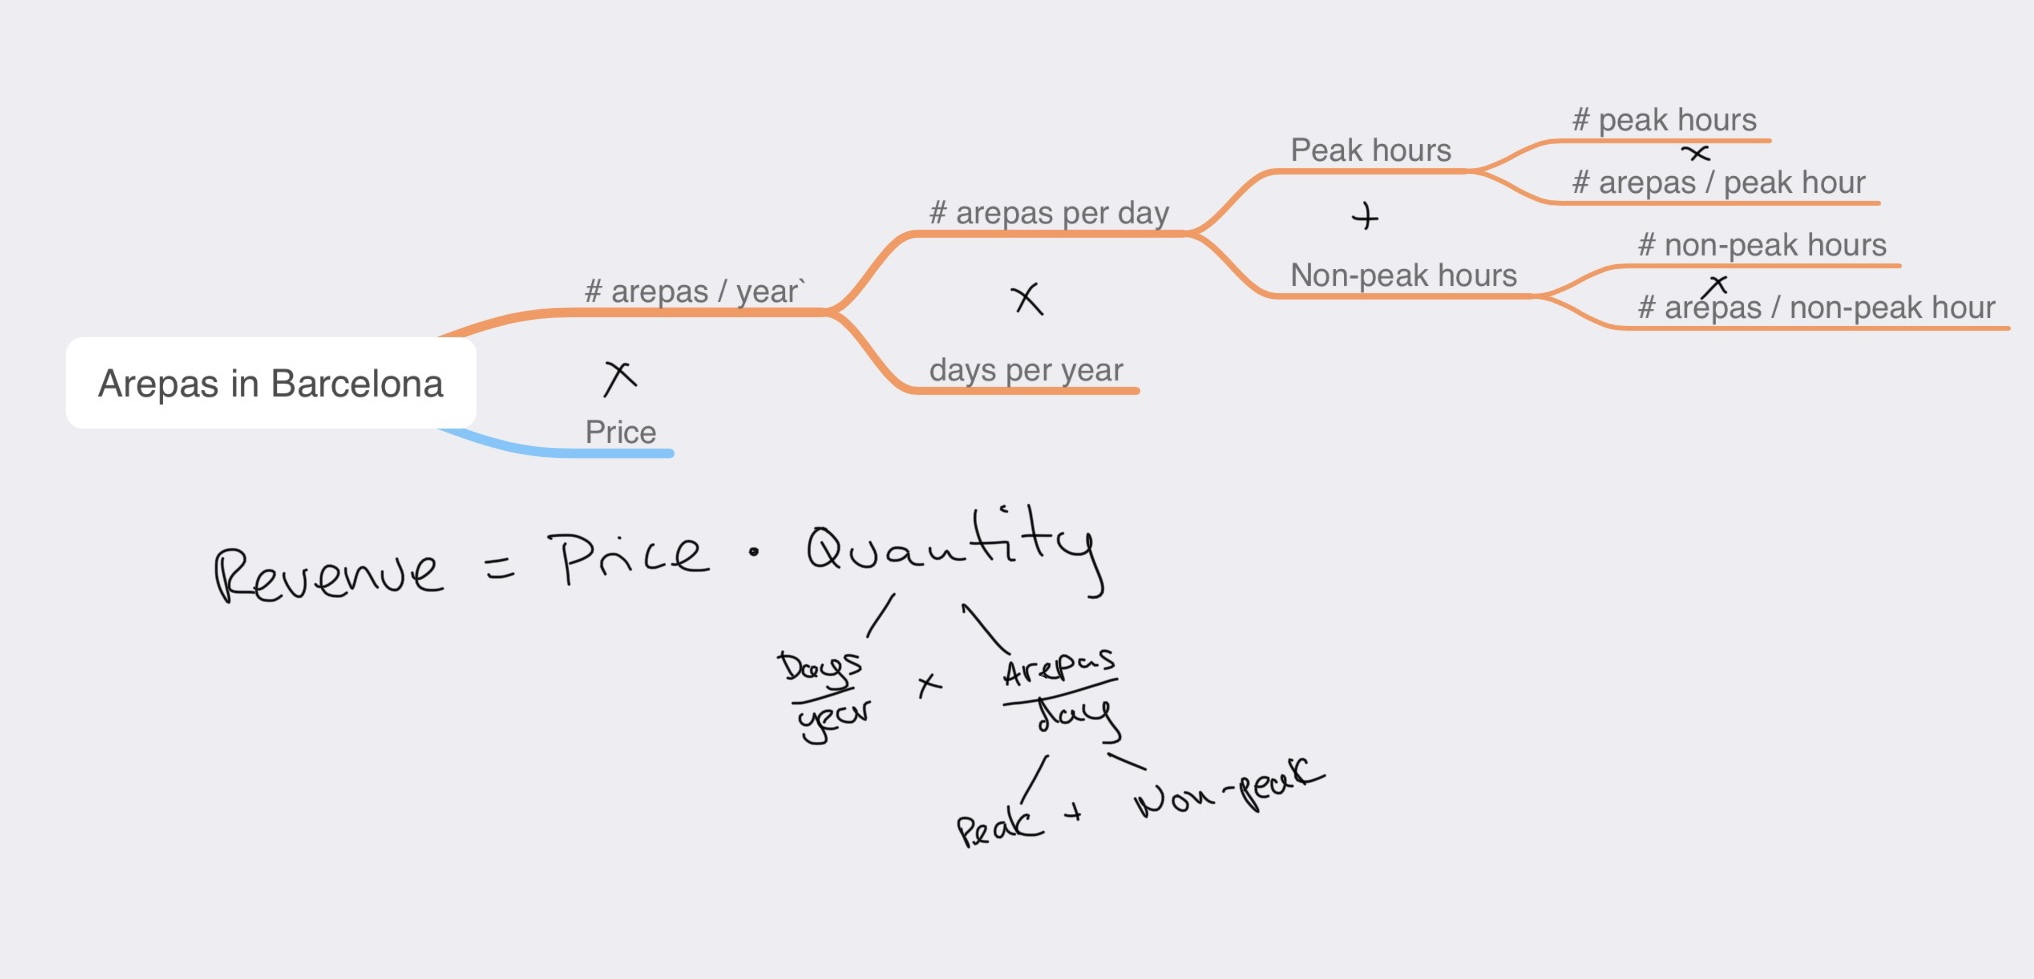

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from scipy.stats import skewnorm
from scipy import stats
import random
from google.colab import files


%matplotlib inline

<a name="assumptions"></a>
## Assumptions

In [11]:
# Creating data frame wit assumptions

#assumptions on dictionary
assumptions = dict()
assumptions['peak_arepas_hour'] = ["discreet",30,40,50,100,0]
assumptions['lazy_arepas_hour'] = ["discreet",10,15,20,35,1]
assumptions['hours_day'] = ["discreet",10,12,12,13,11]
assumptions['peak_hours'] = ["discreet",2,4,5,8,2]
assumptions['days_year'] = ["discreet",345,350,360,365,320]
assumptions['price'] = ["continuous",3,4,6,10,2.5]

#Converting dictionary to data frame
assumptions_df = pd.DataFrame().from_dict(assumptions,orient='index',columns=['type','low(p10)','mid(p50)','high(p90)','max_value','min_value'])
assumptions_df

,type,low(p10),mid(p50),high(p90),max_value,min_value
peak_arepas_hour,discreet,30,40,50,100,0.0
lazy_arepas_hour,discreet,10,15,20,35,1.0
hours_day,discreet,10,12,12,13,11.0
peak_hours,discreet,2,4,5,8,2.0
days_year,discreet,345,350,360,365,320.0
price,continuous,3,4,6,10,2.5


Note: I have no idea how many arepas are **actually** sold during peak or lazy hours. But this is the cool part of how this work, as long as you agree with the overall structure, we can play around with different values for the assumptions to get a more reasonable number

In [12]:
280*350*4

392000


<a name="base_case"></a>

## Base Case Market Sizing

In [13]:
def market_sizing(peak_arepas_hour,lazy_arepas_hour, hours_day,peak_hours, days_year, price):
  ''' 
  Input: assumptions
  Process: market sizing logic
  Output: Market size
  '''
  are_peak_hours = peak_hours * peak_arepas_hour
  lazy_hours = hours_day - peak_hours
  are_lazy_hours = lazy_hours * lazy_arepas_hour
  arepas_day = are_peak_hours + are_lazy_hours
  arepas_year = days_year * arepas_day
  rev_restaurant = arepas_year * price
  return rev_restaurant

In [14]:
#Generate Base case

#Retrieve base case assumptions
base_assumptions = assumptions_df['mid(p50)'].tolist()

#Determine market size with function from cell above
base_case_mkt_size = market_sizing(base_assumptions[0],base_assumptions[1],base_assumptions[2],base_assumptions[3],base_assumptions[4],base_assumptions[5])

print(f'The base case market size is: {base_case_mkt_size/1000} k EUR')

The base case market size is: 392.0 k EUR



<a name="monte"></a>

## Generating Scenarios (Monte Carlo Simulation)

In [15]:
def calc_mtecarlo_vals(x_low, x_mid, x_high):
  ''' 
  INPUT: 
  > Low, mid case and high value for a given assumption
  > [Included in function] z values for percentile 10 and 90

  PROCESS: 
  > Calculate standard deviations using as input the mean (mid case) a data point in p10 and p90 and its z-score
  > Calculate mean of both standard deviations
  > Calculate skewness [Note: I am not confident about how robust this calculation of skewness is; but its better than none. Write to me if you have suggestions to make it better! rrosasl@gmail.com]
  
  OUTPUT:
  Parameters for monte carlo simulation (loc = mean, scale = standard deviation, a = skewness)
  ''' 
  #Z values for p10 and p90
  z_10 = stats.norm.ppf(.1)
  z_90 = stats.norm.ppf(.9)

  loc = x_mid

  #Calculate standard deviations for p1 and p90  
  stdev1 = (x_low - x_mid ) / z_10
  stdev2 = (x_high - x_mid ) / z_90

  #Calculate average of both standard deviations
  avg_stdev = np.mean((stdev1,stdev2))
  scale = avg_stdev

  #Calculating skewness
  diff_high = (x_high-x_mid) / x_mid 
  diff_low = (x_mid - x_low) / x_mid
  a = (diff_high - diff_low) / x_mid
  #Note: Since we divide the difference by the mean, the skewness will never be too large


  return loc, scale,a

In [16]:
def gen_monte_data(loc,scale,a=0,n=10000,max_val=np.nan, min_val = np.nan, discreet=False):
  ''' 
  INPUT: 
  > Mean, Standard Deviation, and Skewness (loc = mean, scale = standard deviation, a = skewness)
  > Number of simulations (n)
  > Max and min values (max_val, min_val)
  > Variable type (discreet vs continuous)

  PROCESS:
  > Create 50% more simulations that hyperparameter (since we will remove the min and max values)
  > Geneate N (+50%) distributions using mean, stdev, and skewness
  > IF there are max and min filters, apply them
  > IF variable is discreet, then round the result to the nearest integer
  > Shuffle the results
  > Retrieve only the values specified by the hyperparameter n

  OUTPUT: Monte Carlo
  > N scenarios of the variable
  ''' 
  
  #Create 50% more simulations that hyperparameter (since we will remove the min and max values)
  n_sim = np.int(n * 1.5)

  #Geneate N (+50%) distributions using mean, stdev, and skewness
  sim_data = skewnorm(a,loc,scale).rvs(n_sim)
  
  #Apply max/min filters
  if np.isnan(max_val) == False:
    sim_data = [a for a in sim_data if a <= max_val]
  
  if np.isnan(min_val) == False:
    sim_data = [a for a in sim_data if a >= min_val]

  #IF variable is discreet, then round the result to the nearest integer
  if discreet == True: 
    sim_data = [int(round(a,0)) for a in sim_data]

  # Retrieve only N from sim_data
  random.shuffle(sim_data)
  sim_data = sim_data[0:n]

  
  return sim_data


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


''

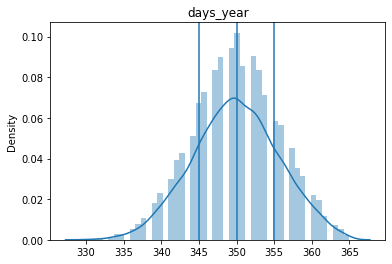

In [17]:
# Testing it directly from assumptions_df
vari = 'days_year'

vals = assumptions_df.loc[vari].tolist()[1:4]
loc, scale, a = calc_mtecarlo_vals(vals[0],vals[1],vals[2])
max_val = assumptions_df.loc[vari,'max_value']
min_val = assumptions_df.loc[vari,'min_value']
discreet = False
if assumptions_df.loc[vari,'type'] == 'discreet':
  discreet = True

data_test =gen_monte_data(loc,scale,a,n=10000,max_val = max_val, min_val = min_val,discreet=discreet)
#Visualize data
sns.distplot(data_test)
#plt.axvline(x=loc)
plt.axvline(np.percentile(data_test,20))
plt.axvline(np.percentile(data_test,80))
#plt.axvline(np.percentile(data_test,10),color='w')
#plt.axvline(np.percentile(data_test,90),color='w')
#plt.axvline(np.percentile(data_test,5),color='w')
#plt.axvline(np.percentile(data_test,95),color='w')

plt.axvline(np.percentile(data_test,50))


plt.title(vari)
;


In [18]:
# Generate dataframe with monte carlo for all assumptions
monte_all = pd.DataFrame()
for vari in assumptions_df.index:
    
    vals = assumptions_df.loc[vari].tolist()[1:4]

    loc, scale, a = calc_mtecarlo_vals(vals[0],vals[1],vals[2])
    max_val = assumptions_df.loc[vari,'max_value']
    min_val = assumptions_df.loc[vari,'min_value']

    discreet = False
    if assumptions_df.loc[vari,'type'] == 'discreet':
      discreet = True
    monte_sim =gen_monte_data(loc,scale,a,n=100000,max_val = max_val, min_val = min_val,discreet=discreet)
    
    monte_all[vari] = monte_sim
monte_all

,peak_arepas_hour,lazy_arepas_hour,hours_day,peak_hours,days_year,price
0,44,14,12,4,361,5.070125
1,37,17,13,4,344,3.666403
2,38,13,12,3,352,3.619418
3,39,20,12,3,347,2.928677
4,34,9,12,5,342,3.823751
...,...,...,...,...,...,...
99995,27,13,12,4,345,3.821355
99996,32,12,13,5,353,2.703871
99997,29,15,11,6,344,4.367214
99998,43,11,13,4,351,2.898729


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<Figure size 1440x1080 with 0 Axes>

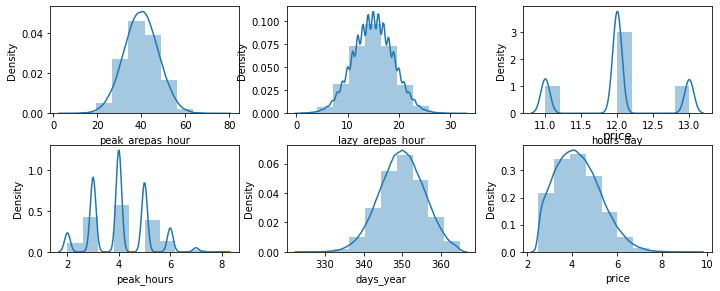

In [19]:
#Graph the distribution of all the variables

plt.figure(figsize=(20,15))
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,4))
fig.tight_layout()
for i, column in enumerate(monte_all):
    sns.distplot(monte_all[column],bins=10,ax=axes[i//3,i%3])

    plt.title(column);



<a name="market_size"></a>

## Calculating Market Size

In [20]:
# Using market sizing function for each scenerio, generating a new column
monte_all['market_size_kEUR'] = market_sizing(monte_all.peak_arepas_hour,monte_all.lazy_arepas_hour,monte_all.hours_day,monte_all.peak_hours,monte_all.days_year,monte_all.price) / 1000

In [21]:
#Displaying results of market size
monte_all.head()

,peak_arepas_hour,lazy_arepas_hour,hours_day,peak_hours,days_year,price,market_size_kEUR
0,44,14,12,4,361,5.070125,527.130739
1,37,17,13,4,344,3.666403,379.634014
2,38,13,12,3,352,3.619418,294.302086
3,39,20,12,3,347,2.928677,301.826570
4,34,9,12,5,342,3.823751,304.699428


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Market Size for Arepa Restaurant in Barcelona, Revenue (k EUR) per year')

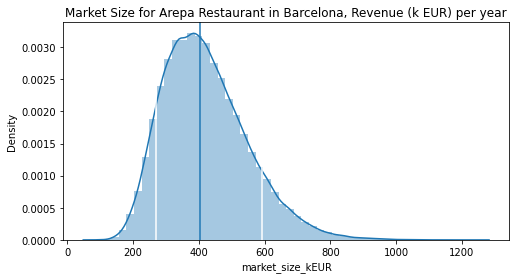

In [22]:
# Visualizing the resulting market size of the N simulations 

plt.figure(figsize=(8,4))

vis_data = monte_all['market_size_kEUR']
sns.distplot(vis_data)
#plt.axvline(np.percentile(vis_data,20))
#plt.axvline(np.percentile(vis_data,80))
plt.axvline(np.percentile(vis_data,10),color='w')
plt.axvline(np.percentile(vis_data,90),color='w')
#plt.axvline(np.percentile(vis_data,5),color='w')
#plt.axvline(np.percentile(vis_data,95),color='w')

plt.axvline(np.percentile(vis_data,50))

plt.title('Market Size for Arepa Restaurant in Barcelona, Revenue (k EUR) per year')

#plt.savefig('msize.png')
#files.download('msize.png');

In [23]:
# Print statements with results

print(f'Median Market size is : {round(vis_data.median(),2)} k EUR')
print(f'It is unlikely (less than 10% probability), that the market is less than : {round(np.percentile(vis_data,10),1)} k EUR')
print(f'It is unlikely (more than 10% probability), that the market is more than : {round(np.percentile(vis_data,90),1)} k EUR')


Median Market size is : 404.73 k EUR
It is unlikely (less than 10% probability), that the market is less than : 269.4 k EUR
It is unlikely (more than 10% probability), that the market is more than : 592.8 k EUR



<a name="feature_importance"></a>

## Feature Importance

In [24]:
# Copying data frame, just in case
monte_all_sensitivity = monte_all.copy()


In [25]:
# Displaying original assumptions for convenience
assumptions_df

,type,low(p10),mid(p50),high(p90),max_value,min_value
peak_arepas_hour,discreet,30,40,50,100,0.0
lazy_arepas_hour,discreet,10,15,20,35,1.0
hours_day,discreet,10,12,12,13,11.0
peak_hours,discreet,2,4,5,8,2.0
days_year,discreet,345,350,360,365,320.0
price,continuous,3,4,6,10,2.5


Logic: 

1. Take mid value for each variable
2. Compute market sizes
3. Compare average market with initial average monte carlo avg market size






In [26]:
# Calculating average market size
base_avg = monte_all_sensitivity.market_size_kEUR.median()
base_avg

404.7327771325681

In [27]:
''' 
Calculating importance of each variable

Process: 
> Loop through each variable 
> restart the monte carlo data frame
> Calculate sensitivity for each value of assumption (low, middle, high)
>>> First, set ALL the values for all the scenario with the static assumption (low, mid, or high)
>>> Second, re-calculate the market size
>>> Third, calculate the average of all the market sizes
> Store all the values on the sensitivity_dict dictionary
> Convert it to dataframe

''' 

sensitivity_dict = dict()

for assu in assumptions_df.index:
  monte_all_sensitivity = monte_all.copy()

  #MidPoint
  monte_all_sensitivity[assu] = assumptions_df.loc[assu,'mid(p50)'] #set ALL the values for all the scenario with the static assumption
  #re-calculate the market size
  monte_all_sensitivity['market_size_mn_sensitivity'] = market_sizing(monte_all_sensitivity.peak_arepas_hour,monte_all_sensitivity.lazy_arepas_hour,monte_all_sensitivity.hours_day,monte_all_sensitivity.peak_hours,monte_all_sensitivity.days_year,monte_all_sensitivity.price) / 1000
  sensitivity_market_size_mid = monte_all_sensitivity['market_size_mn_sensitivity'].mean() #calculate the average of all the market sizes

  #Low
  monte_all_sensitivity[assu] = assumptions_df.loc[assu,'low(p10)']
  monte_all_sensitivity['market_size_mn_sensitivity'] = market_sizing(monte_all_sensitivity.peak_arepas_hour,monte_all_sensitivity.lazy_arepas_hour,monte_all_sensitivity.hours_day,monte_all_sensitivity.peak_hours,monte_all_sensitivity.days_year,monte_all_sensitivity.price) / 1000
  sensitivity_market_size_low = monte_all_sensitivity['market_size_mn_sensitivity'].mean()

  # High
  monte_all_sensitivity[assu] = assumptions_df.loc[assu,'high(p90)']
  monte_all_sensitivity['market_size_mn_sensitivity'] = market_sizing(monte_all_sensitivity.peak_arepas_hour,monte_all_sensitivity.lazy_arepas_hour,monte_all_sensitivity.hours_day,monte_all_sensitivity.peak_hours,monte_all_sensitivity.days_year,monte_all_sensitivity.price) / 1000
  sensitivity_market_size_high = monte_all_sensitivity['market_size_mn_sensitivity'].mean()

  #Combining
  sensitivity_dict[assu] = sensitivity_market_size_low, sensitivity_market_size_mid, sensitivity_market_size_high

sensitivity_df = pd.DataFrame().from_dict(sensitivity_dict,orient='index',columns=['market_size_low','market_size_mid','market_size_high'])
sensitivity_df['baseline'] = base_avg
#sensitivity_df['importance'] = abs(sensitivity_df.market_size_mid - sensitivity_df.baseline)
sensitivity_df['width'] = sensitivity_df.market_size_high - sensitivity_df.market_size_low

sensitivity_df


,market_size_low,market_size_mid,market_size_high,baseline,width
peak_arepas_hour,359.871658,420.543133,481.214608,404.732777,121.342950
lazy_arepas_hour,361.060018,420.332907,479.605796,404.732777,118.545778
hours_day,375.634018,420.460919,420.460919,404.732777,44.826901
peak_hours,343.461499,418.051040,455.345810,404.732777,111.884312
days_year,414.467160,420.473931,432.487472,404.732777,18.020311
price,295.448789,393.931718,590.897577,404.732777,295.448789


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

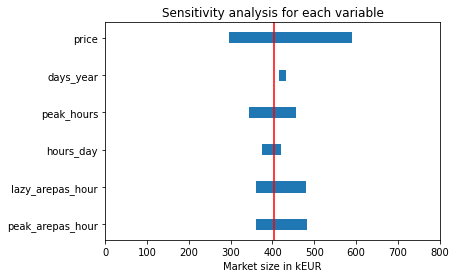

In [ ]:
# Visualizing sensitivity
width = sensitivity_df.width.tolist()
left = sensitivity_df.market_size_low.tolist()
y = range(0,sensitivity_df.shape[0])
fig, ax = plt.subplots(figsize=(6,4))
ax.barh(width=width, left=left, height=0.3,y=y)

labels = sensitivity_df.index.tolist()
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels)
plt.xlim([0, 800])
plt.axvline(base_avg,color='red')
plt.title('Sensitivity analysis for each variable')
plt.xlabel('Market size in kEUR')
;

file_name = 'sens_analysis.png'
plt.savefig(file_name,bbox_inches='tight')

files.download(file_name)

##Sensitivity in model
This is an optional step; it's just calculating the feature importance based on the logical model without considering the uncertainty we have in the assumptions

In [ ]:
base_assumptions = assumptions_df['mid(p50)'].tolist()
base_case_mkt_size = market_sizing(base_assumptions[0],base_assumptions[1],base_assumptions[2],base_assumptions[3],base_assumptions[4],base_assumptions[5])
print(f'The base case market size is: {base_case_mkt_size/1000} k EUR')


sens_model = dict()
for i in range(0,len(base_assumptions)):
  base_assumptions_copy = base_assumptions.copy()
  base_assumptions_copy[i] = base_assumptions_copy[i] * 1.1
  sensitivity_mkt_size = market_sizing(base_assumptions_copy[0],base_assumptions_copy[1],base_assumptions_copy[2],base_assumptions_copy[3],base_assumptions_copy[4],base_assumptions_copy[5])

  sens_model[assumptions_df.index[i]] = base_assumptions[i],base_assumptions_copy[i],sensitivity_mkt_size

sensitivity_model = pd.DataFrame().from_dict(sens_model,orient='index',columns=['original_assumption','senssitivity_assumption','sens_mkt_size'])
sensitivity_model['base_case'] = base_case_mkt_size
sensitivity_model['diff'] = sensitivity_model['sens_mkt_size'] - sensitivity_model['base_case']
sensitivity_model

The base case market size is: 392.0 k EUR


,original_assumption,senssitivity_assumption,sens_mkt_size,base_case,diff
peak_arepas_hour,40,44.0,414400.0,392000,22400.0
lazy_arepas_hour,15,16.5,408800.0,392000,16800.0
hours_day,12,13.2,417200.0,392000,25200.0
peak_hours,4,4.4,406000.0,392000,14000.0
days_year,350,385.0,431200.0,392000,39200.0
price,4,4.4,431200.0,392000,39200.0


''

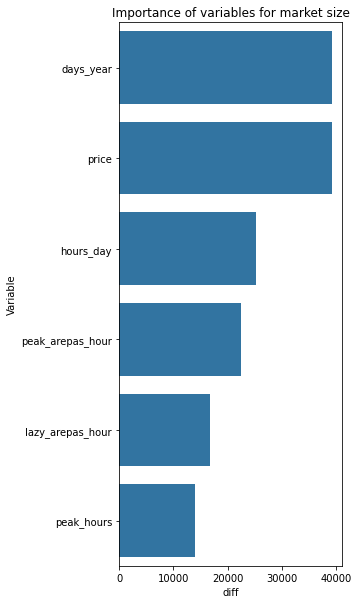

In [ ]:
plt.figure(figsize=(4,10))

vis_df = sensitivity_model.reset_index().sort_values(by='diff',ascending=False)

sns.barplot(data=vis_df,y='index',x='diff',color=sns.color_palette()[0])
plt.title('Importance of variables for market size')
plt.ylabel("Variable")

;